Dungeon Data Analysis 
--- 

--- 

## 1. Imports

--- 

In [1]:
import pandas as pd
import json
import numpy as np
import pyvista
import nbformat
from IPython.display import display_markdown
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import minmax_scale
import os

In [190]:
# Generate TOC requires file to be saved 
with open('DungeonDataExploration.ipynb', 'r',  encoding="utf8") as f:
    nb = nbformat.read(f, as_version=4)

    toc = ""
existingCells = []

# generates table of contents 
for cell in nb.cells:
    if(cell.cell_type=="markdown" and cell.source[0] == "#" if len(cell.source) > 0 else False):
        # get cell name 
        heading = cell.source.split("\n")[0]
        if heading.count("#") > 1 and not (heading in existingCells):
            existingCells.append(heading);
            toc += (heading.count("#")-1)*'&emsp;&emsp;'+ "["+heading.strip("#")+"]" +"(#"+heading.strip("#")[1:].replace(" ","-").removesuffix("-")+")"+ "<br/>" # use fprint

In [191]:
# Display TOC
display_markdown("---", raw =True)
display_markdown(toc, raw=True)

---

&emsp;&emsp;[ 1. Imports](#1.-Imports)<br/>&emsp;&emsp;[ 2. Dungeon Stats](#2.-Dungeon-Stats)<br/>&emsp;&emsp;&emsp;&emsp;[ 2.1 Data Pre-Processing ](#2.1-Data-Pre-Processing)<br/>&emsp;&emsp;&emsp;&emsp;[ 2.2 Data Visualisation](#2.2-Data-Visualisation)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 2.2.1 Room Types](#2.2.1-Room-Types)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 2.2.2 Distance from Start](#2.2.2-Distance-from-Start)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 2.2.3 RoomMainSplit](#2.2.3-RoomMainSplit)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 2.2.4 Number of Connections per Room](#2.2.4-Number-of-Connections-per-Room)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 2.2.5 Types of Corridors Generated](#2.2.5-Types-of-Corridors-Generated)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 2.2.6 Corridor Positions](#2.2.6-Corridor-Positions)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 2.2.7 Dungeon Spatial Density](#2.2.7-Dungeon-Spatial-Density)<br/>&emsp;&emsp;[ 3. Player Navgation](#3.-Player-Navgation)<br/>&emsp;&emsp;&emsp;&emsp;[ 3.1 Data Pre-Processing](#3.1-Data-Pre-Processing)<br/>&emsp;&emsp;&emsp;&emsp;[ 3.2 Data Visualisation ](#3.2-Data-Visualisation)<br/>&emsp;&emsp;[ 4. System Performance](#4.-System-Performance)<br/>&emsp;&emsp;&emsp;&emsp;[ 4.1 Data Pre-Processing](#4.1-Data-Pre-Processing)<br/>&emsp;&emsp;&emsp;&emsp;[ 4.2 Data Visualisation](#4.2-Data-Visualisation)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 4.2.1 Frames Per Second](#4.2.1-Frames-Per-Second)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 4.2.2 Triangle Count](#4.2.2-Triangle-Count)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 4.2.3 System Memory Used](#4.2.3-System-Memory-Used)<br/>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[ 4.2.3 Draw Calls](#4.2.3-Draw-Calls)<br/>

## 2. Dungeon Stats
--- 

### 2.1 Data Pre-Processing 
--- 

In [4]:
dungeonData["dungeonConfig"]

{'maxIterations': 5,
 'dungeonBounds': {'m_Position': {'x': 10, 'y': 0, 'z': 40},
  'm_Size': {'x': 75, 'y': 11, 'z': 62}},
 'splitCenterDeviation': {'x': 0.0, 'y': 0.0, 'z': 0.699999988079071},
 'roomBoundsMin': {'m_Position': {'x': 0, 'y': 0, 'z': 0},
  'm_Size': {'x': 10, 'y': 10, 'z': 10}},
 'roomOffsetMin': {'x': 1, 'y': 1, 'z': 3},
 'roomPlacementRandomness': {'x': 0, 'y': 0, 'z': 0},
 'seededGenerationEnabled': False,
 'randomSeed': 641383510,
 'corridorWidth': 1,
 'corridorHeight': 2,
 'wallThickness': 1}

In [3]:
# for single dungeonTest file process the raw data


individualDungeonStats = [];

for testNumber in range(1,4):

    with open(f"dungeonTest{testNumber}.json") as f:
        dungeonData = json.load(f)
    
    print(dungeonData.keys())

    roomsDF = pd.DataFrame(dungeonData["dungeonStats"]["roomStats"])
    
    doorPositions = ["Right", "Left", "Bottom", "Top"]
    verticalPositions = ["Up", "Down"]
    
    for position in doorPositions:
        roomsDF[f'doorConnection_{position}'] = roomsDF['doorConnections'].apply(lambda x : position in x); 
    roomsDF.drop("doorConnections", axis = 1, inplace = True)
    
    
    for position in verticalPositions:
        roomsDF[f'verticalConnection_{position}'] = roomsDF['verticalConnections'].apply(lambda x : position in x); 
    roomsDF.drop("verticalConnections", axis = 1, inplace = True)
    
    # split xyz for room position and size
    
    room_pos = roomsDF["roomPosition"].apply(pd.Series);
    room_pos.columns = ["roomPos_x","roomPos_y","roomPos_z"];
    roomsDF = roomsDF.drop("roomPosition", axis = 1);
    
    room_size = roomsDF["roomSize"].apply(pd.Series);
    room_size.columns = ["roomSize_x","roomSize_y","roomSize_z"];
    roomsDF = roomsDF.drop("roomSize", axis = 1);
    
    roomsDF = pd.concat([roomsDF, room_pos, room_size], axis = 1)
    #roomsDF.assign(**dungeonData["deviceInfo"])

    individualDungeonStats.append(roomsDF);


dict_keys(['deviceInfo', 'dungeonConfig', 'dungeonStats', 'trackedPerformanceData'])
dict_keys(['deviceInfo', 'dungeonConfig', 'dungeonStats', 'trackedPerformanceData'])
dict_keys(['deviceInfo', 'dungeonConfig', 'dungeonStats', 'trackedPerformanceData'])


In [178]:
# for allRoomsTest file
with open(f"SplitCenterDeviationDensity/allRoomStats_SplitDeviation_0.json") as f:
    allRoomStatsJSON = json.load(f)

In [4]:
def flatten(nested):
    for item in nested:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

In [180]:
allRoomStats = flatten([roomStats["roomStats"] for roomStats in allRoomStatsJSON["allRoomStats"]])

In [181]:
allRoomStatsDF = pd.DataFrame(allRoomStats)

In [183]:
doorPositions = ["Right", "Left", "Bottom", "Top"]
verticalPositions = ["Up", "Down"]

for position in doorPositions:
    allRoomStatsDF[f'doorConnection_{position}'] = allRoomStatsDF['doorConnections'].apply(lambda x : position in x); 
allRoomStatsDF.drop("doorConnections", axis = 1, inplace = True)


for position in verticalPositions:
    allRoomStatsDF[f'verticalConnection_{position}'] = allRoomStatsDF['verticalConnections'].apply(lambda x : position in x); 
allRoomStatsDF.drop("verticalConnections", axis = 1, inplace = True)

# split xyz for room position and size

room_pos = allRoomStatsDF["roomPosition"].apply(pd.Series);
room_pos.columns = ["roomPos_x","roomPos_y","roomPos_z"];
allRoomStatsDF = allRoomStatsDF.drop("roomPosition", axis = 1);

room_size = allRoomStatsDF["roomSize"].apply(pd.Series);
room_size.columns = ["roomSize_x","roomSize_y","roomSize_z"];
allRoomStatsDF = allRoomStatsDF.drop("roomSize", axis = 1);

allRoomStatsDF = pd.concat([allRoomStatsDF, room_pos, room_size], axis = 1)
#roomsDF.assign(**dungeonData["deviceInfo"])



In [228]:
display(allDungeonStats.head());

,numberOfConnection,distanceFromStart,roomType,corridorType,roomMainSplit,roomID,doorConnection_Right,doorConnection_Left,doorConnection_Bottom,doorConnection_Top,verticalConnection_Up,verticalConnection_Down,roomPos_x,roomPos_y,roomPos_z,roomSize_x,roomSize_y,roomSize_z
0,2,2,Room,None,Left,5,True,False,True,False,False,False,0,0,36,31,10,19
1,2,3,End,None,Right,6,False,True,True,False,False,False,45,0,36,24,10,11
2,3,1,Room,None,Left,9,True,False,True,True,False,False,0,0,15,32,9,12
3,2,2,Room,None,Right,10,False,True,False,True,False,False,55,0,16,12,9,10
4,2,0,Start,None,Left,7,True,False,False,True,False,False,0,0,0,32,10,11


### 2.2 Data Visualisation
--- 

#### 2.2.1 Room Types

--- 

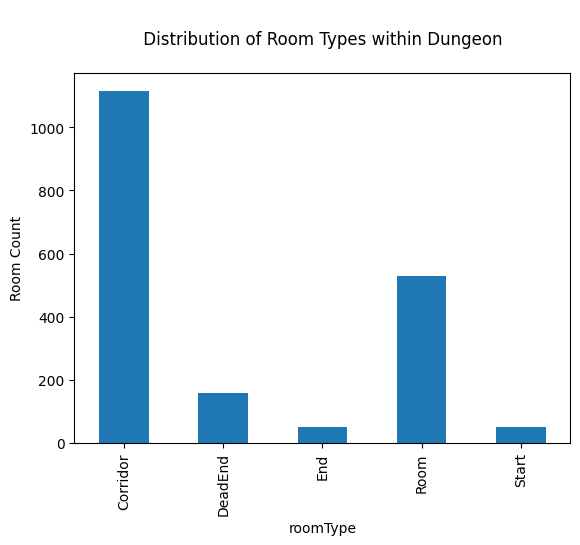

In [229]:
# plot dungeon distribution of room types
allRoomStatsDF.value_counts("roomType").sort_index().plot(kind="bar")
plt.ylabel("Room Count");
plt.title("\n Distribution of Room Types within Dungeon \n");

#### 2.2.2 Distance from Start
--- 

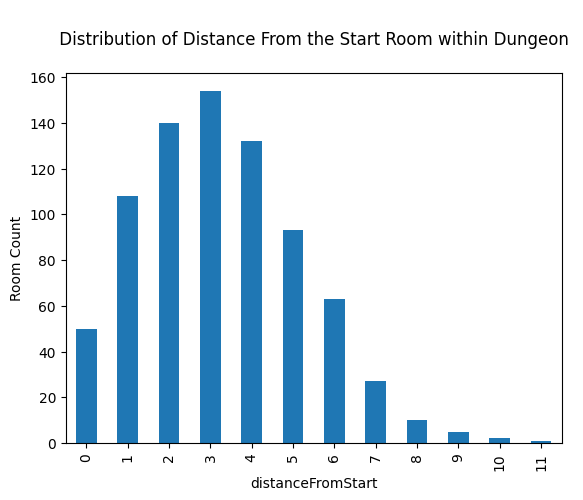

In [230]:
# plot dungeon distribution of distance from the start
plt.ylabel("Room Count");
allRoomStatsDF[allRoomStatsDF.roomType != "Corridor"].value_counts("distanceFromStart").sort_index().plot(kind="bar")
plt.title("\n Distribution of Distance From the Start Room within Dungeon \n");

#### 2.2.3 RoomMainSplit
--- 

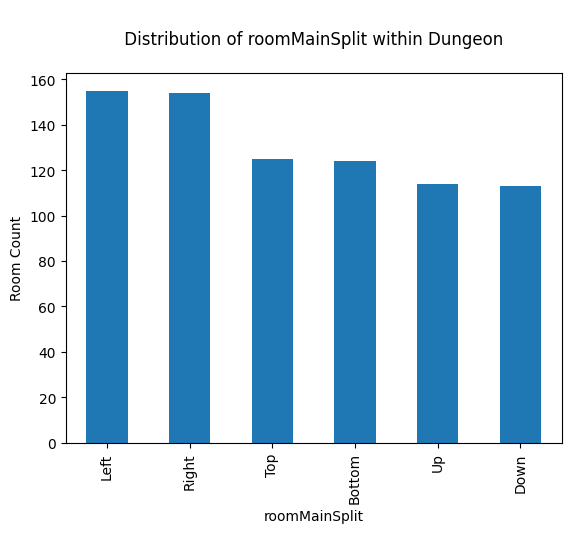

In [231]:
# plot dungeon distribution of split directions of rooms
plt.ylabel("Room Count");
allRoomStatsDF[allRoomStatsDF.roomType != "Corridor"].value_counts("roomMainSplit").plot(kind="bar")
plt.title("\n Distribution of roomMainSplit within Dungeon \n");

#### 2.2.4 Number of Connections per Room
--- 

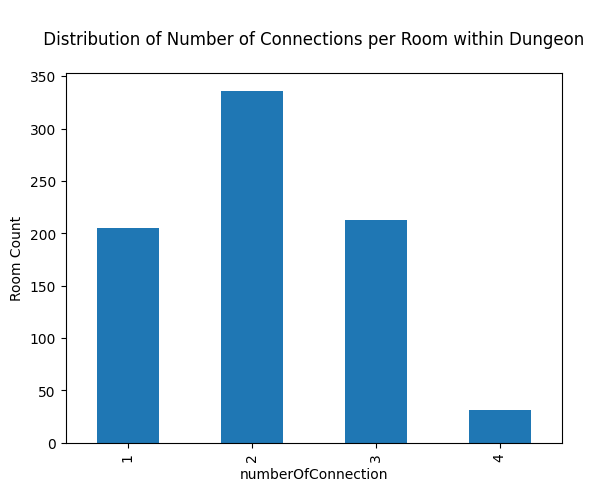

In [232]:
# plot dungeon distribution of connections per room
allRoomStatsDF[allRoomStatsDF.roomType != "Corridor"].value_counts("numberOfConnection").sort_index().plot(kind="bar")
plt.ylabel("Room Count");
plt.title("\n Distribution of Number of Connections per Room within Dungeon \n");

#### 2.2.5 Types of Corridors Generated
--- 

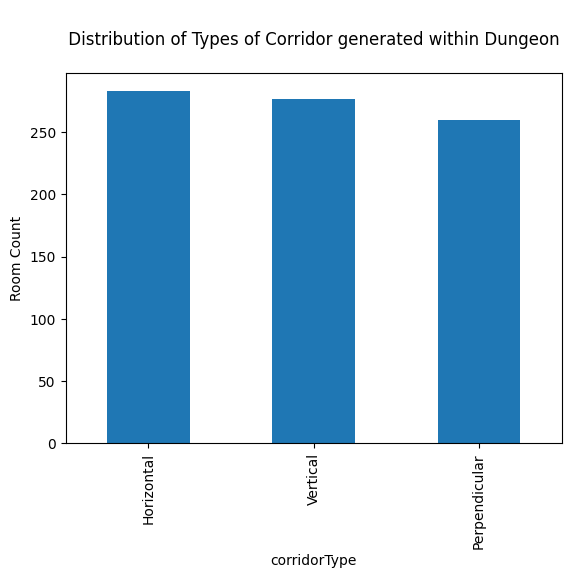

In [233]:
# plot dungeon distribution of types fo corridors generated
allRoomStatsDF[allRoomStatsDF.corridorType != "None"].value_counts("corridorType").plot(kind="bar");
plt.ylabel("Room Count");
plt.title("\n Distribution of Types of Corridor generated within Dungeon \n");

#### 2.2.6 Corridor Positions
--- 

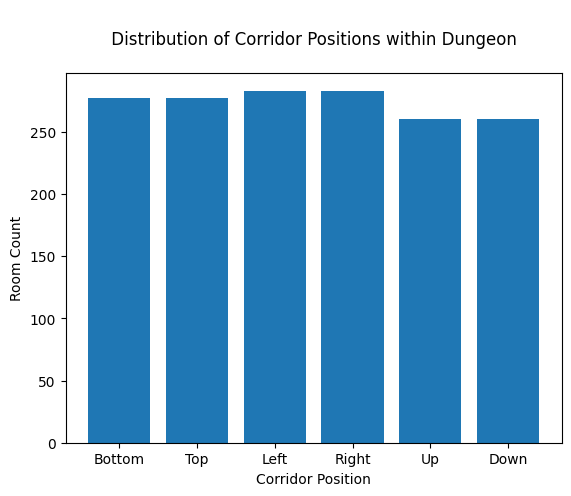

In [234]:
# plot dungeon distribution of Corridor Positions
connectionData = allRoomStatsDF[allRoomStatsDF.corridorType == "None"][["doorConnection_Bottom", 
                                                                         "doorConnection_Top", 
                                                                         "doorConnection_Left", 
                                                                         "doorConnection_Right",
                                                                        "verticalConnection_Up",
                                                                        "verticalConnection_Down"]]
labels = [connectionType.split("_")[1] for connectionType in connectionData.sum().index.to_list()];
plt.bar(labels, connectionData.sum())
plt.ylabel("Room Count");
plt.xlabel("Corridor Position");
plt.title("\n Distribution of Corridor Positions within Dungeon \n");

#### 2.2.7 Dungeon Spatial Density
--- 

In [59]:
with open(f"SplitCenterDeviationDensity/allRoomStats_SplitDeviation_1.0.json") as f:
    allRoomStatsJSON = json.load(f)

In [60]:
allRoomStats = flatten([roomStats["roomStats"] for roomStats in allRoomStatsJSON["allRoomStats"]])

In [61]:
allRoomStatsDF = pd.DataFrame(allRoomStats)

In [62]:
doorPositions = ["Right", "Left", "Bottom", "Top"]
verticalPositions = ["Up", "Down"]

for position in doorPositions:
    allRoomStatsDF[f'doorConnection_{position}'] = allRoomStatsDF['doorConnections'].apply(lambda x : position in x); 
allRoomStatsDF.drop("doorConnections", axis = 1, inplace = True)


for position in verticalPositions:
    allRoomStatsDF[f'verticalConnection_{position}'] = allRoomStatsDF['verticalConnections'].apply(lambda x : position in x); 
allRoomStatsDF.drop("verticalConnections", axis = 1, inplace = True)

# split xyz for room position and size

room_pos = allRoomStatsDF["roomPosition"].apply(pd.Series);
room_pos.columns = ["roomPos_x","roomPos_y","roomPos_z"];
allRoomStatsDF = allRoomStatsDF.drop("roomPosition", axis = 1);

room_size = allRoomStatsDF["roomSize"].apply(pd.Series);
room_size.columns = ["roomSize_x","roomSize_y","roomSize_z"];
allRoomStatsDF = allRoomStatsDF.drop("roomSize", axis = 1);

allRoomStatsDF = pd.concat([allRoomStatsDF, room_pos, room_size], axis = 1)

In [63]:
# calculate frequency of occupied points 

occupiedPoints = {};

#for roomsDF in individualDungeonStats:
justRoomData = allRoomStatsDF[allRoomStatsDF.roomType != "Corridor"];

roomSizeData = np.array(list(zip(justRoomData['roomSize_x'], justRoomData['roomSize_y'], justRoomData['roomSize_z'])));
roomData = np.array(list(zip(justRoomData['roomPos_x'], justRoomData['roomPos_y'], justRoomData['roomPos_z'])));

for position, size in zip(roomData,roomSizeData):
    
    for x in range(size[0]):
        for y in range(size[1]):
            for z in range(size[2]):

                location = tuple(position+np.array([x,y,z]))
                
                if location in occupiedPoints:
                    occupiedPoints[location] += 1;
                else:
                    occupiedPoints[location] = 1

In [66]:
# set values for point cloud
point_cloud = pyvista.PolyData(np.array(list(occupiedPoints.keys()),dtype=np.float32))
point_cloud["Times Occupied"] = np.array(list(occupiedPoints.values()))

In [67]:
# plot the point cloud
plotter = pyvista.Plotter()
plotter.add_points(point_cloud, point_size=5, render_points_as_spheres=True, opacity = 0.3, clim=(0,50))  
plotter.add_text("Point Cloud Showing Density of Room Placements", font_size=14) 
plotter.show()

Widget(value='<iframe src="http://localhost:39427/index.html?ui=P_0x7f805bae52e0_9&reconnect=auto" class="pyvi…

## 3. Player Navgation
--- 

- Sizes of Dungeons
- 2D / 3D

### 3.1 Data Pre-Processing
--- 

In [5]:
with open(f"3D_Generation.json") as f:
    playerData = json.load(f)

In [5]:
from collections import Counter

In [78]:
def plot_dungeonPath(data):
    # process data
    roomsDF = pd.DataFrame(data["dungeonStats"]["roomStats"])
    
    doorPositions = ["Right", "Left", "Bottom", "Top"]
    verticalPositions = ["Up", "Down"]
    
    for position in doorPositions:
        roomsDF[f'doorConnection_{position}'] = roomsDF['doorConnections'].apply(lambda x : position in x); 
    roomsDF.drop("doorConnections", axis = 1, inplace = True)
    
    
    for position in verticalPositions:
        roomsDF[f'verticalConnection_{position}'] = roomsDF['verticalConnections'].apply(lambda x : position in x); 
    roomsDF.drop("verticalConnections", axis = 1, inplace = True)
    
    # split xyz for room position and size
    
    room_pos = roomsDF["roomPosition"].apply(pd.Series);
    room_pos.columns = ["roomPos_x","roomPos_y","roomPos_z"];
    roomsDF = roomsDF.drop("roomPosition", axis = 1);
    
    room_size = roomsDF["roomSize"].apply(pd.Series);
    room_size.columns = ["roomSize_x","roomSize_y","roomSize_z"];
    roomsDF = roomsDF.drop("roomSize", axis = 1);
    
    roomsDF = pd.concat([roomsDF, room_pos, room_size], axis = 1)

    # merge on visisted rooms 
    # merge the room position and room and id
    visitedRooms = roomsDF[roomsDF.roomID.isin(data["trackedPerformanceData"]["roomIDsVisited"])]
    
    visitedRoomLoc = [];
    meshes_sphere = [];
    roomFreqs = Counter(data["trackedPerformanceData"]["roomIDsVisited"])
    maxVisits = max(roomFreqs.values());
    roomFreqs = {k: 2*v/maxVisits for k, v in roomFreqs.items()};
    locationFreq_dict = {};
    
    for roomID in data["trackedPerformanceData"]["roomIDsVisited"]:
        roomStats = visitedRooms[visitedRooms.roomID == roomID]
        location = np.array(roomStats[['roomPos_x','roomPos_y','roomPos_z']]) + np.array([roomStats["roomSize_x"].values[0]/2, 0, roomStats["roomSize_z"].values[0]/2]);
        visitedRoomLoc.append(location); # add offset to center
        meshes_sphere.append(pyvista.Sphere(roomFreqs[roomID],location))
        
        locationFreq_dict[roomID] = (location,roomFreqs[roomID]);
    
    visitedRoomLoc = [pos[0] for pos in visitedRoomLoc]; 
    
    # generate meshes to represent the boundaries of the rooms in the dungeon 
    meshes_boxes = [];
    roomSizeData = np.array(list(zip(visitedRooms['roomSize_x'], visitedRooms['roomSize_y'], visitedRooms['roomSize_z'])));
    roomData = np.array(list(zip(visitedRooms['roomPos_x'], visitedRooms['roomPos_y'], visitedRooms['roomPos_z'])));
    for position, size in zip(roomData,roomSizeData):
        mesh = pyvista.Box((position[0], position[0]+size[0], position[1], position[1]+size[1], position[2], position[2]+size[2]))
        meshes_boxes.append(mesh);
    
    # scale the timestamps for collection to apply to the colormap
    timestamps_scaled = list(minmax_scale(np.array(data["trackedPerformanceData"]["timeStampsVisited"])))

    # visualisation using poly-line in pyvista

    polyline = pyvista.PolyData(visitedRoomLoc)
    
    segments = np.full((len(visitedRoomLoc)-1, 3), 2, dtype=np.int_)  
    segments[:, 1] = np.arange(0, len(visitedRoomLoc)-1)
    segments[:, 2] = np.arange(1, len(visitedRoomLoc))
    
    polyline.lines = segments
    polyline["time"] = timestamps_scaled;

    # plot the players path within the dungeon using pyvista

    plotter = pyvista.Plotter()
    plotter.add_mesh(polyline, scalars="time", cmap="coolwarm", line_width=3, show_scalar_bar=True) 

    plotter.camera_position="zy";
    plotter.camera.azimuth -= 45
    plotter.camera.elevation += 10
    plotter.enable_parallel_projection()
    
    for mesh in meshes_sphere:
        plotter.add_mesh(mesh, style='wireframe');

     # ------------------------------
    # plot isolines
    points = [item[0][0] for item in list(locationFreq_dict.values())];
    points = np.array(list(points)) 
    frequencies = [item[1] for item in list(locationFreq_dict.values())];
    cloud = pyvista.PolyData(points)
    cloud["frequency"] = frequencies
    

    surf = cloud.delaunay_3d()
    shell = surf.extract_geometry().triangulate()
    contours = shell.contour(isosurfaces=3, scalars="frequency")

    plotter.add_mesh(contours, color="grey", line_width=0.1)  # contour lines


    # ------------------------------
    plotter.add_text("Player Path inside Dungeon", font_size=14, position=(0.5, 0.95)) 
    plotter.show()
        
    

In [85]:
plot_dungeonPath(play_tests["eneme"]["SizeTest"]["Generation_20"])

Widget(value='<iframe src="http://localhost:35921/index.html?ui=P_0x7f7ccc61e480_25&reconnect=auto" class="pyv…

In [287]:
frequencies = np.random.randint(1, 50, size=21)
polyline["frequency"] = frequencies

In [69]:
points = [item[0][0] for item in list(locationFreq_dict.values())];
points = np.array(list(points)) 
frequencies = [item[1] for item in list(locationFreq_dict.values())];

cloud = pyvista.PolyData(points)
cloud["frequency"] = frequencies

surf = cloud.delaunay_3d()
shell = surf.extract_geometry().triangulate()
contours = shell.contour(isosurfaces=4, scalars="frequency")

plotter = pyvista.Plotter()
#plotter.add_mesh(contours, color="black", line_width=2)  # contour lines
plotter.add_points(points, color="red", point_size=5)
plotter.add_text("Contour Lines of Player Movement", font_size=12)
plotter.add_mesh(shell, opacity = 0.4);

plotter.camera_position="zy";
plotter.camera.azimuth -= 45
plotter.camera.elevation += 10
plotter.enable_parallel_projection()
    

plotter.show()

Widget(value='<iframe src="http://localhost:35921/index.html?ui=P_0x7f7e7c5300e0_14&reconnect=auto" class="pyv…

In [77]:
roomsDF = pd.DataFrame(playerData["dungeonStats"]["roomStats"])
    
doorPositions = ["Right", "Left", "Bottom", "Top"]
verticalPositions = ["Up", "Down"]

for position in doorPositions:
    roomsDF[f'doorConnection_{position}'] = roomsDF['doorConnections'].apply(lambda x : position in x); 
roomsDF.drop("doorConnections", axis = 1, inplace = True)


for position in verticalPositions:
    roomsDF[f'verticalConnection_{position}'] = roomsDF['verticalConnections'].apply(lambda x : position in x); 
roomsDF.drop("verticalConnections", axis = 1, inplace = True)

# split xyz for room position and size

room_pos = roomsDF["roomPosition"].apply(pd.Series);
room_pos.columns = ["roomPos_x","roomPos_y","roomPos_z"];
roomsDF = roomsDF.drop("roomPosition", axis = 1);

room_size = roomsDF["roomSize"].apply(pd.Series);
room_size.columns = ["roomSize_x","roomSize_y","roomSize_z"];
roomsDF = roomsDF.drop("roomSize", axis = 1);

roomsDF = pd.concat([roomsDF, room_pos, room_size], axis = 1)

In [80]:
# merge the room position and room and id
visitedRooms = roomsDF[roomsDF.roomID.isin(playerData["trackedPerformanceData"]["roomIDsVisited"])]


visitedRoomLoc = [];
for roomID in playerData["trackedPerformanceData"]["roomIDsVisited"]:
    roomStats = visitedRooms[visitedRooms.roomID == roomID]
    visitedRoomLoc.append(np.array(roomStats[['roomPos_x','roomPos_y','roomPos_z']]) 
                          + np.array([roomStats["roomSize_x"].values[0]/2, 0, roomStats["roomSize_z"].values[0]/2])); # add offset to center

visitedRoomLoc = [pos[0] for pos in visitedRoomLoc]; 

# generate meshes to represent the boundaries of the rooms in the dungeon 
meshes_boxes = [];
roomSizeData = np.array(list(zip(visitedRooms['roomSize_x'], visitedRooms['roomSize_y'], visitedRooms['roomSize_z'])));
roomData = np.array(list(zip(visitedRooms['roomPos_x'], visitedRooms['roomPos_y'], visitedRooms['roomPos_z'])));
for position, size in zip(roomData,roomSizeData):
    mesh = pyvista.Box((position[0], position[0]+size[0], position[1], position[1]+size[1], position[2], position[2]+size[2]))
    meshes_boxes.append(mesh);

# scale the timestamps for collection to apply to the colormap
timestamps_scaled = list(minmax_scale(np.array(playerData["trackedPerformanceData"]["timeStampsVisited"])))

### 3.2 Data Visualisation 
--- 

In [81]:
# poly-line to draw players path within the dungeon

polyline = pyvista.PolyData(visitedRoomLoc)

segments = np.full((len(visitedRoomLoc)-1, 3), 2, dtype=np.int_)  
segments[:, 1] = np.arange(0, len(visitedRoomLoc)-1)
segments[:, 2] = np.arange(1, len(visitedRoomLoc))

polyline.lines = segments
polyline["time"] = timestamps_scaled;

In [82]:
# plot the players path within the dungeon using pyvista

plotter = pyvista.Plotter()
plotter.add_mesh(polyline, scalars="time", cmap="coolwarm", line_width=3, show_scalar_bar=True) 

for mesh in meshes_boxes:
    plotter.add_mesh(mesh, style='wireframe');

plotter.add_text("Player Path inside Dungeon", font_size=14, position=(0.5, 0.95)) 
plotter.show()

Widget(value='<iframe src="http://localhost:46403/index.html?ui=P_0x7f9c88ecbb00_0&reconnect=auto" class="pyvi…

 JS Error => error: Uncaught TypeError: Cannot mix BigInt and other types, use explicit conversions
 JS Error => error: Uncaught TypeError: Cannot mix BigInt and other types, use explicit conversions
 JS Error => error: Uncaught TypeError: Cannot mix BigInt and other types, use explicit conversions


## 4. System Performance
---

- Based on Different Devices
- Sizes of Dungeon
- 2D / 3D
- with / without voxel remeshing

### 4.1 Data Pre-Processing
---

In [30]:
dungeonData["trackedPerformanceData"]

{'fps': [50, 66, 61],
 'triangles': [0, 286083, 189917],
 'systemMemoryUsed': [1531, 1553, 1562],
 'drawCallsCount': [0, 0, 0],
 'roomIDsVisited': [8, 7, 10, 9, 5, 6],
 'timeStampsVisited': [0.34915003180503845,
  3.5079281330108643,
  6.252799034118652,
  10.586281776428223,
  17.108177185058594,
  22.9112491607666],
 'timeStampsCollected': [4.489550590515137,
  7.127844333648682,
  11.590742111206055,
  18.274208068847656,
  24.791519165039062]}

### 4.2 Data Visualisation
---

In [3]:
import os
machine_dict = {};
performance_dir = "PerformanceTesting";
for directory in os.listdir(performance_dir):
    performance_dict = {};
    machine_dir = os.path.join(performance_dir, directory)
    
    for filename in os.listdir(machine_dir):
        fpath = os.path.join(machine_dir, filename)
    
        if os.path.isfile(fpath):
          with open(fpath) as f:
            performanceBasedData = json.load(f)
            performance_dict[performanceBasedData["dungeonConfig"]["maxIterations"]] = performanceBasedData["trackedPerformanceData"];
            performance_dict[performanceBasedData["dungeonConfig"]["maxIterations"]]["generationTime"] = performanceBasedData["dungeonStats"]["GenerationTime"]


        machine_dict[directory] = performance_dict
    
    print(performanceBasedData["deviceInfo"])

{'Model': '17Z90P-G.AA76G (LG Electronics)', 'GraphicsCard': 'Intel(R) Iris(R) Xe Graphics', 'VRAM': 8, 'OS': 'Windows 11  (10.0.22631) 64bit', 'CPU': '11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz', 'Resolution': '2560 x 1600 @ 60.0028589807734Hz'}
{'Model': 'System Product Name (ASUS)', 'GraphicsCard': 'NVIDIA GeForce RTX 4070 Ti', 'VRAM': 11, 'OS': 'Windows 11  (10.0.26100) 64bit', 'CPU': '13th Gen Intel(R) Core(TM) i7-13700KF', 'Resolution': '1920 x 1080 @ 60Hz'}


In [4]:
metric_name_dict = {
    "fps":"Frames Per Second (FPS)",
    "triangles": "Triangle Count (Count)",
    "systemMemoryUsed": "System Memory Used (MB)",
    "generationTime": "Generation Time (milliseconds)"
}

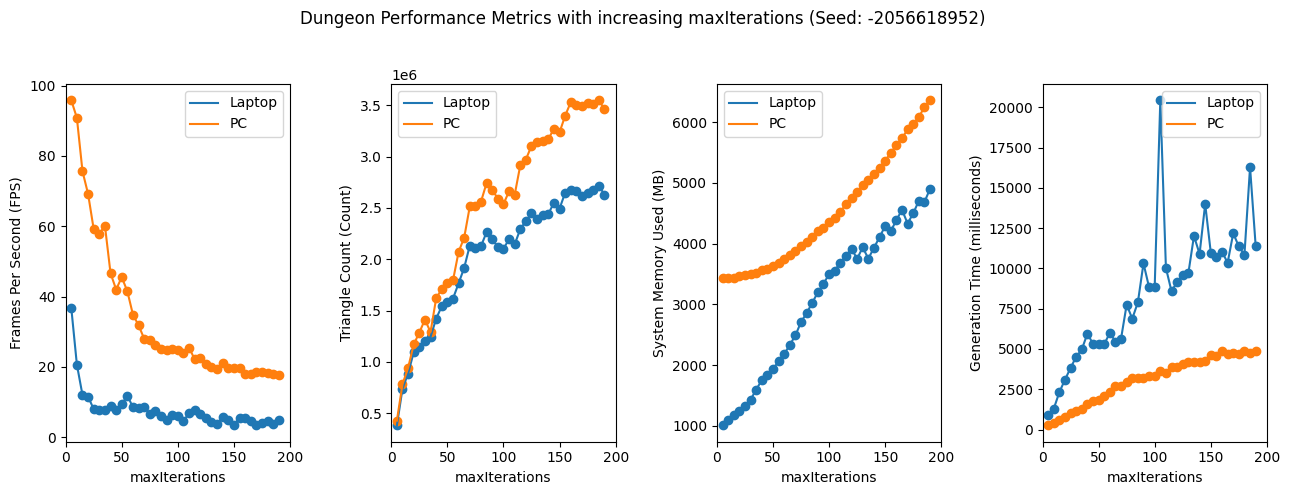

In [5]:
trackedPerformanceMetrics = metric_name_dict.keys()
fig, ax = plt.subplots(1, 4, figsize=(13, 5))

for machine in machine_dict.keys():
    performance_dict = machine_dict[machine]
    for i,metric in enumerate(trackedPerformanceMetrics):
        sorted_iter, sorted_fps = zip(*sorted(zip(performance_dict.keys(), [np.average(val[metric]) for val in performance_dict.values()])))
        ax[i].set_ylabel(metric_name_dict[metric])
        ax[i].set_xlabel("maxIterations")
        ax[i].plot(sorted_iter, sorted_fps, label = machine);
        ax[i].scatter(sorted_iter, sorted_fps)
        ax[i].legend();
        ax[i].set_xlim(0,200)
        ax[i].set_xlim(0,200)

plt.suptitle("Dungeon Performance Metrics with increasing maxIterations (Seed: -2056618952) \n");
fig.tight_layout();

plt.show();

print()

--- 

In [86]:
playtest_dir = "PlayTests";

play_tests = {};
for user in os.listdir(playtest_dir):
    user_dir = os.path.join(playtest_dir, user)
    play_tests[user] = {};
    
    for test in os.listdir(user_dir):
        test_dir = os.path.join(user_dir, test)
        play_tests[user][test] = {}
        
        for config in os.listdir(test_dir):
            
            config_dir = os.path.join(test_dir, config)
            play_tests[user][test][config] = {}
            
            for playTestData in os.listdir(config_dir):
                if playTestData.endswith(".json"):
                     with open(os.path.join(config_dir, playTestData)) as f:
                        playTestDataJSON = json.load(f)
                        play_tests[user][test][config] = playTestDataJSON
                    

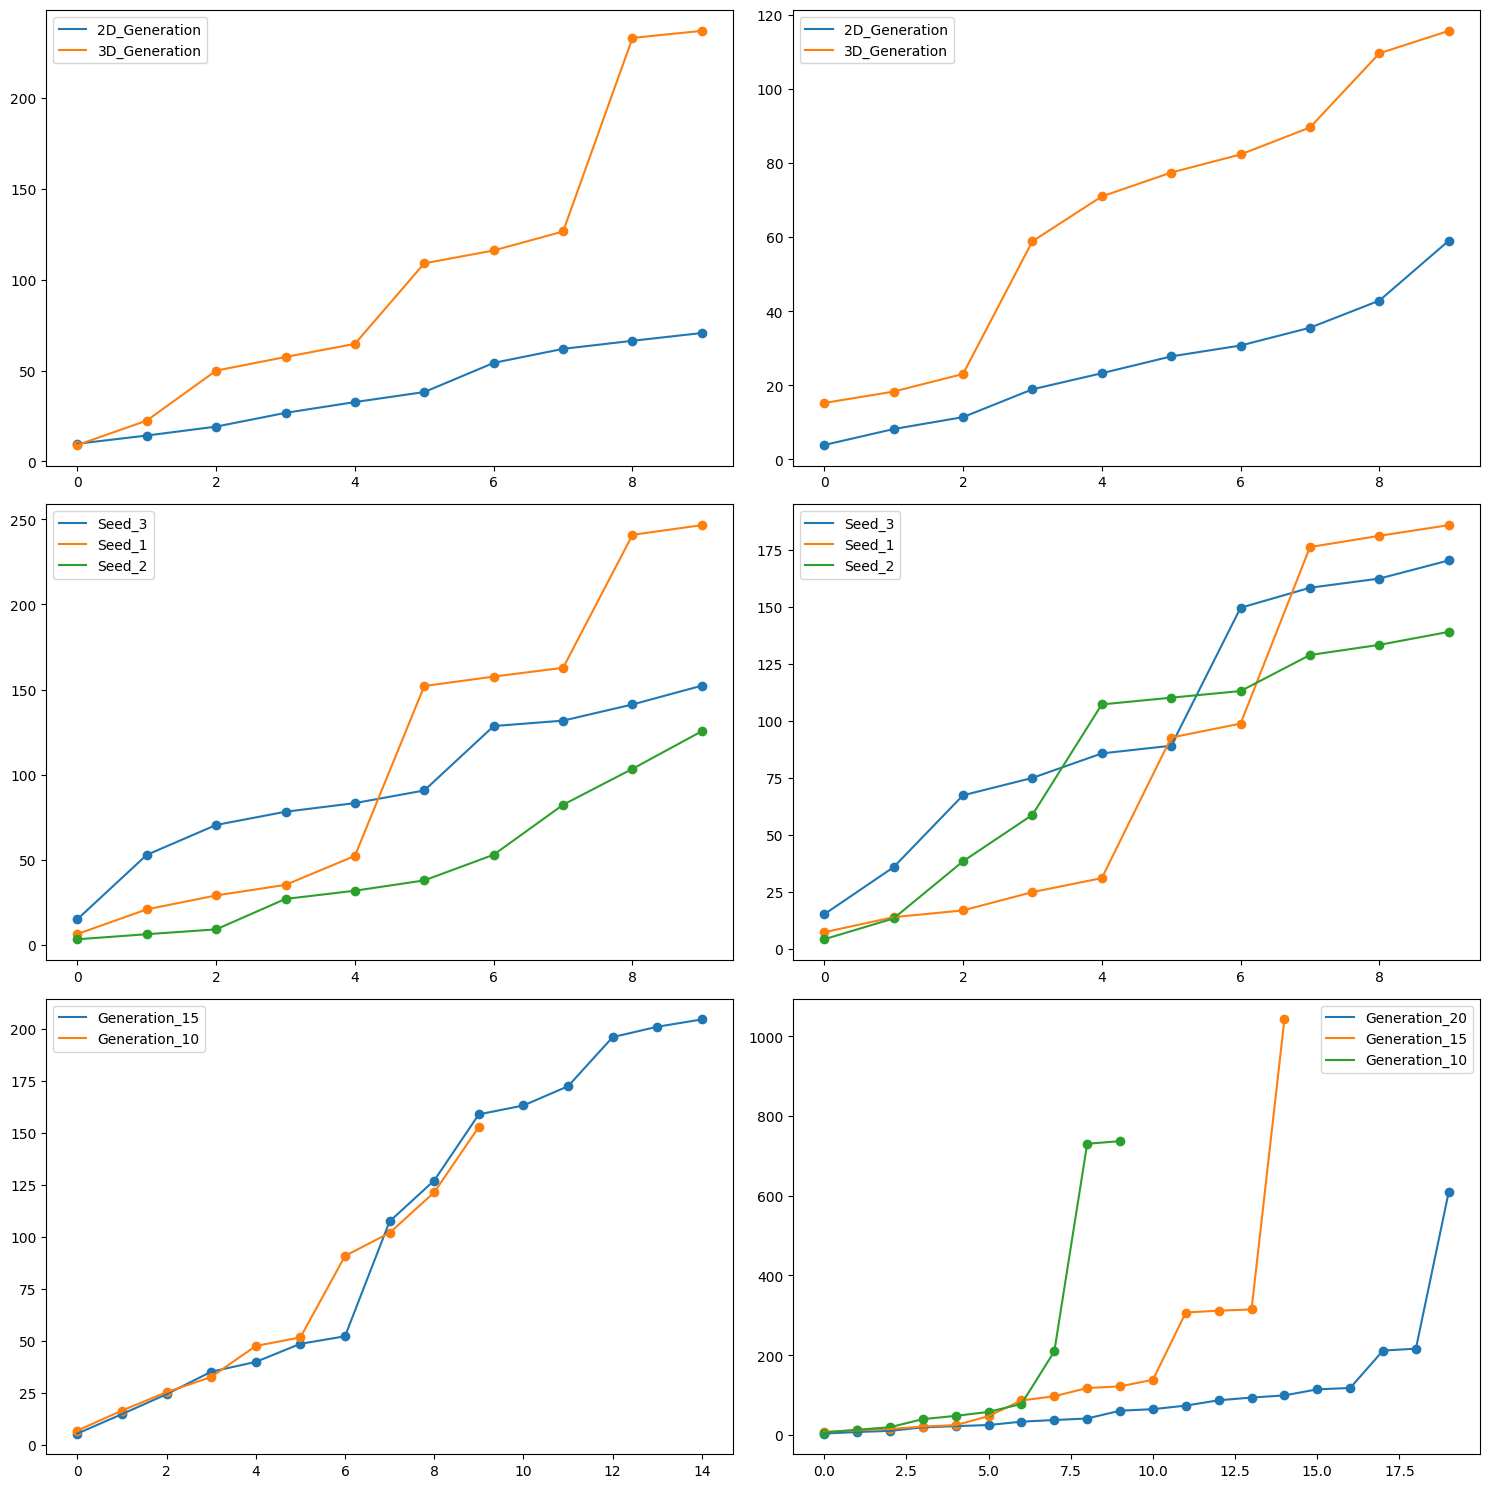

In [74]:
fig, axs = plt.subplots(max(len(tests) for tests in play_tests.values()), 2, figsize=(15, 15))

for userIndex, (user, tests) in enumerate(play_tests.items()):

    for testNumber, (test, configs) in enumerate(tests.items()):
        
        for configIndex, (config, playtests) in enumerate(configs.items()):
            for playtest_name, data in playtests.items():


                timeStampsCollected_data = data["trackedPerformanceData"]["timeStampsCollected"];
                axs[testNumber][userIndex].scatter(np.arange(len(timeStampsCollected_data)),timeStampsCollected_data)
                axs[testNumber][userIndex].plot(np.arange(len(timeStampsCollected_data)),timeStampsCollected_data, label = playtest_name)
                axs[testNumber][userIndex].legend()

fig.tight_layout();

In [87]:
test_explanation_dict = {
    "ConnectionTest":"Connection Test (2D vs. 3D)",
    "SeedTest":"Seed Test (Different Seeds)",
    "SizeTest":"Size Test (Different maxIterations)"
}

In [92]:
import matplotlib.ticker as ticker

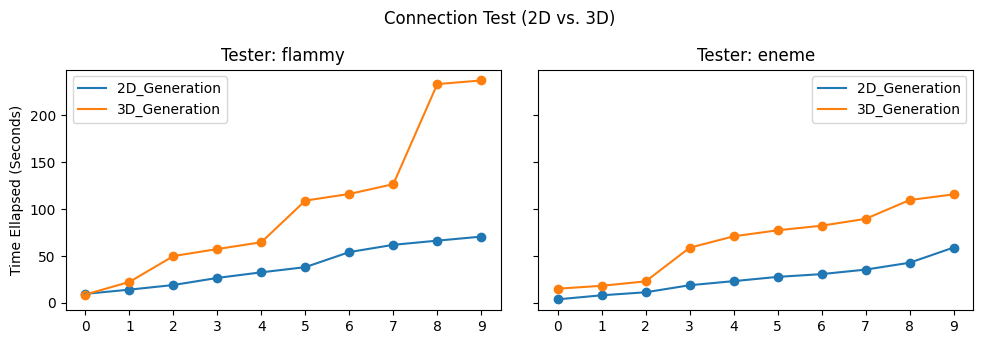

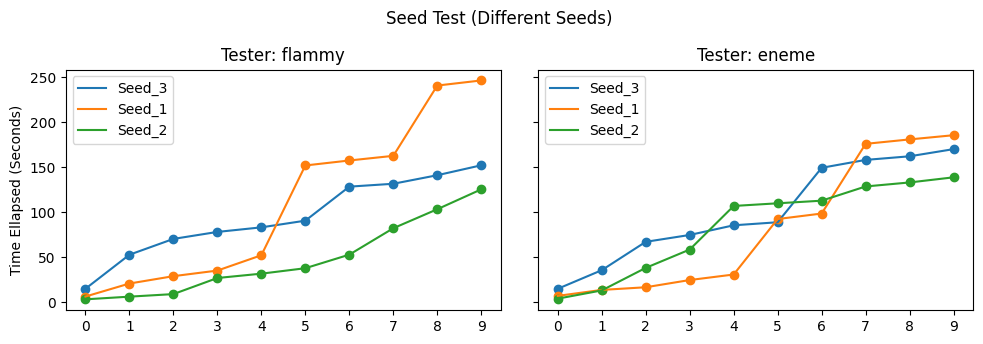

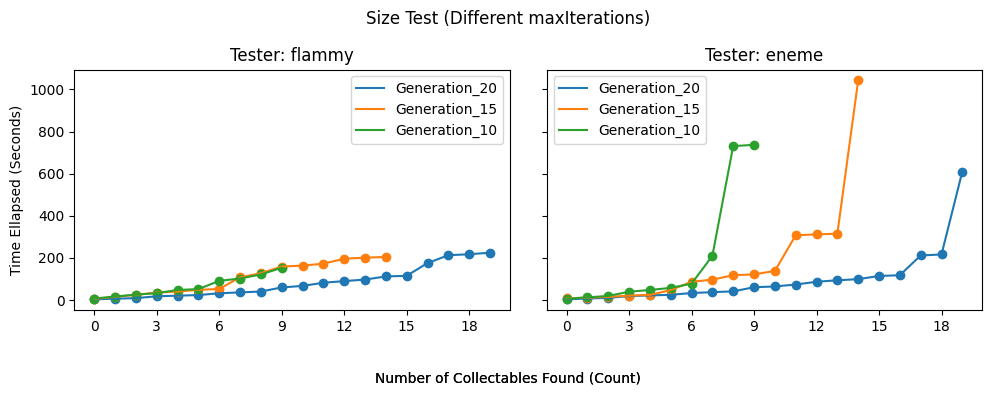

In [93]:
testPlot_axs_dict = {};
for userIndex, (user, tests) in enumerate(play_tests.items()):
    
    for testNumber, (test, configs) in enumerate(tests.items()):
        
        if testPlot_axs_dict.get(test) is None:
           fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey = True )
           testPlot_axs_dict[test] = axs;

           axs[0].set_ylabel("Time Ellapsed (Seconds)")
           fig.tight_layout();

           fig.text(0.5, 1.1, test_explanation_dict[test], va='center', ha='center', rotation='horizontal', fontsize=12)
     
        
        for configIndex, (config, data) in enumerate(configs.items()):
            
            testPlot_axs_dict[test][userIndex].set_title("Tester: " + user);
            timeStampsCollected_data = data["trackedPerformanceData"]["timeStampsCollected"];
            testPlot_axs_dict[test][userIndex].scatter(np.arange(len(timeStampsCollected_data)),timeStampsCollected_data)
            testPlot_axs_dict[test][userIndex].plot(np.arange(len(timeStampsCollected_data)),timeStampsCollected_data, label = config)
            testPlot_axs_dict[test][userIndex].legend()
            testPlot_axs_dict[test][userIndex].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
            
    fig.text(0.5, -0.1, 'Number of Collectables Found (Count)', va='center', ha='center', rotation='horizontal', fontsize=10)


--- 

### Visualizing Difficulty in Navigation

In [137]:
plot_dungeonPath(play_tests["eneme"]["SizeTest"]["Generation_20"])

Widget(value='<iframe src="http://localhost:39427/index.html?ui=P_0x7f7fa87d1a60_16&reconnect=auto" class="pyv…

--- 

In [14]:
original_dims = np.array([50, 50, 50])
original_volume = np.prod(original_dims)

ratios = [0.25, 0.5, 0.75, 1, 1/0.25, 1/0.5, 1/0.75]
#np.concat([np.linspace(0.1,1,4), 1/np.linspace(0.1,1,4)])


new_dim_array = []

for r1 in ratios:
    for r2 in ratios:
        for r3 in ratios:
            if r1 * r2 * r3 == 1:
                new_dims = np.array([r1, r2, r3]) * original_dims;
                new_dim_array.append((new_dims, np.random.randint(1000)));
                
                


In [15]:
# set values for point cloud
point_cloud = pyvista.PolyData([x[0] for x in new_dim_array])
point_cloud["values"] = [x[1] for x in new_dim_array]

In [17]:
# plot the point cloud
plotter = pyvista.Plotter()
plotter.add_points(point_cloud, point_size=5, render_points_as_spheres=True, opacity = 0.3)  
plotter.add_text("Point Cloud Showing Density of Room Placements", font_size=14) 
plotter.show()

Widget(value='<iframe src="http://localhost:33555/index.html?ui=P_0x7f96984b0080_2&reconnect=auto" class="pyvi…

### SplitCenterDeviation

In [129]:
dungeon_size_bias_dir = "DungeonSizeBias";

dungeon_size_tests = {};
for test in os.listdir(dungeon_size_bias_dir):
      with open(os.path.join(dungeon_size_bias_dir, test)) as f:
        playTestDataJSON = json.load(f)
        dungeon_size_tests[test.split(".json")[0]] = playTestDataJSON

In [130]:
corridor_types_per_size = {};
for testName, testData in dungeon_size_tests.items():
    # combine doorConnections and verticalConnections
    corridor_type_list = [];
    for generationInstance in testData["allRoomStats"]:
        for room in generationInstance["roomStats"]:
            if room["corridorType"] != "None":
                corridor_type_list.append(room["corridorType"])
    corridor_types_per_size[testName] = corridor_type_list;

In [138]:
testConfig_stats = {};
for testName, testData in dungeon_size_tests.items():
     with open(os.path.join("DungeonSizeBias/test_Configs", testName+"_config.json")) as f:
        test_ConfigJSON = json.load(f)
        testConfig_stats[testName] = test_ConfigJSON

In [131]:
corridorType_conversion_dict = {
    "Perpendicular": "Y-Axis",
    "Vertical": "Z-Axis",
    "Horizontal": "X-Axis"
}

{'maxIterations': 20, 'dungeonBounds': {'m_Position': {'x': 10, 'y': 0, 'z': 40}, 'm_Size': {'x': 40, 'y': 40, 'z': 80}}, 'splitCenterDeviation': {'x': 0.5, 'y': 0.5, 'z': 0.5}, 'roomBoundsMin': {'m_Position': {'x': 0, 'y': 0, 'z': 0}, 'm_Size': {'x': 10, 'y': 10, 'z': 10}}, 'roomOffsetMin': {'x': 3, 'y': 3, 'z': 3}, 'roomPlacementRandomness': {'x': 0, 'y': 0, 'z': 0}, 'seededGenerationEnabled': False, 'randomSeed': -1336828905, 'corridorWidth': 1, 'corridorHeight': 2, 'wallThickness': 1}
{'maxIterations': 20, 'dungeonBounds': {'m_Position': {'x': 10, 'y': 0, 'z': 40}, 'm_Size': {'x': 40, 'y': 80, 'z': 40}}, 'splitCenterDeviation': {'x': 0.5, 'y': 0.5, 'z': 0.5}, 'roomBoundsMin': {'m_Position': {'x': 0, 'y': 0, 'z': 0}, 'm_Size': {'x': 10, 'y': 10, 'z': 10}}, 'roomOffsetMin': {'x': 3, 'y': 3, 'z': 3}, 'roomPlacementRandomness': {'x': 0, 'y': 0, 'z': 0}, 'seededGenerationEnabled': False, 'randomSeed': -1336828905, 'corridorWidth': 1, 'corridorHeight': 2, 'wallThickness': 1}
{'maxIterati

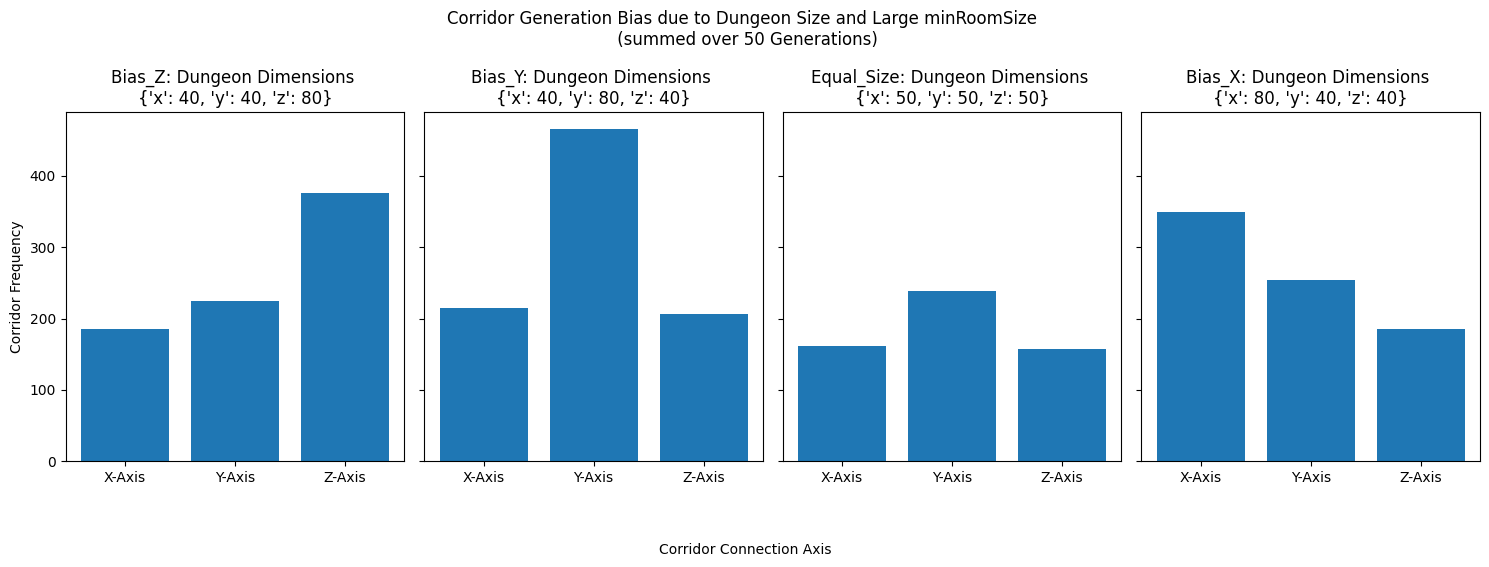

In [169]:
from collections import Counter

fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey = True)
axs[0].set_ylabel("Corridor Frequency");
for i, (testName, corridorTypes) in enumerate(corridor_types_per_size.items()):
    corridor_counts = Counter(corridorTypes)

    corridor_order = ['Horizontal', 'Perpendicular', 'Vertical'] 
    counts_ordered = [corridor_counts.get(c, 0) for c in corridor_order]
    
    bar_labels = [corridorType_conversion_dict[corridorType] for corridorType in corridor_order]
    
    axs[i].bar(bar_labels, counts_ordered)

    graph_title = f'{testName}: Dungeon Dimensions \n{str(testConfig_stats[testName]["dungeonBounds"]["m_Size"])}';
    axs[i].set_title(graph_title)
    print(testConfig_stats[testName])
plt.suptitle("Corridor Generation Bias due to Dungeon Size and Large minRoomSize \n (summed over 50 Generations)");
fig.text(0.5, -0.1, 'Corridor Connection Axis', va='center', ha='center', rotation='horizontal', fontsize=10)
fig.tight_layout();
plt.show();